# Imports

In [62]:
from __future__ import print_function, division
from utils import *
import numpy as np
import skimage as sk
import skimage.io as skio
import math
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.exposure import rescale_intensity
import time
from skimage import feature,io, transform
import cv2 as cv
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from skimage.color import rgb2gray
import math
from scipy.spatial.transform import Rotation as R
import seaborn as sns
import cv2
import random
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.transform import warp
from scipy import misc
import numpy as np
import sys
import math
import random
from skimage.transform import rescale, resize, downscale_local_mean

# 1)Random Sampling

In [63]:
#Choose Image you want to generate sample for over here
im= skio.imread("pebbles.jpg")

In [64]:
im.shape


(200, 296, 3)

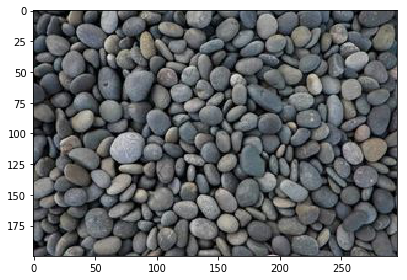

In [65]:
skio.imshow(im)

In [66]:
im

array([[[ 15,  17,  16],
        [ 20,  22,  21],
        [ 11,  13,  12],
        ...,
        [ 52,  51,  56],
        [ 25,  25,  27],
        [ 45,  45,  47]],

       [[ 60,  62,  61],
        [ 31,  33,  32],
        [ 30,  32,  31],
        ...,
        [ 76,  75,  80],
        [ 44,  43,  48],
        [ 46,  45,  50]],

       [[ 86,  88,  87],
        [ 50,  52,  51],
        [ 52,  54,  53],
        ...,
        [ 74,  75,  79],
        [ 48,  49,  53],
        [ 48,  49,  53]],

       ...,

       [[107, 104, 115],
        [109, 106, 115],
        [110, 107, 116],
        ...,
        [ 56,  59,  66],
        [ 28,  31,  38],
        [  0,   0,   7]],

       [[108, 106, 117],
        [105, 103, 114],
        [101,  99, 110],
        ...,
        [ 84,  87,  94],
        [ 55,  58,  65],
        [ 13,  16,  23]],

       [[107, 105, 118],
        [102, 100, 113],
        [ 96,  94, 105],
        ...,
        [ 86,  89,  96],
        [ 68,  71,  78],
        [ 31,  34,  41]]

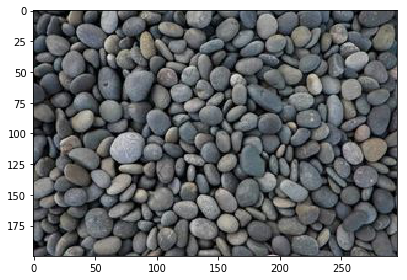

In [67]:
skio.imshow(im)

In [68]:
#TODO- FIX DIRECTION STUFF
def quilt_random(sample, outsize, patchsize):
    sample = sample.copy() / 255.0
    # X coordinate and Y coordinate should be within bounds so that if we add patchsize, image is not out of bounds
    output_image= np.zeros((outsize,outsize,3))
    im_size_x= sample.shape[0]
    im_size_y= sample.shape[1]
    for row_number in range(int(outsize/patchsize)):
        for col_number in range(int(outsize/patchsize)):            
            current_x= col_number*patchsize
            current_y=row_number*patchsize         
            rand_x= random.randint(patchsize,im_size_x-patchsize)
            rand_y= random.randint(patchsize,im_size_y-patchsize)
            direction_list=[-1,1]
            # After chosing a point do we go left or right for sample direction
            x_direction= random.choice(direction_list)
            # After chosing a point and left or right do we go up or down for sample direction
            y_direction= random.choice(direction_list)
            #Random patch based on randomly chosen point in the middle and randomly chosen x + y directions
            random_patch= sample[rand_x:rand_x+(patchsize),rand_y:rand_y+(patchsize)]
            output_image[current_x:current_x+patchsize,current_y:current_y+patchsize]= random_patch
    return output_image



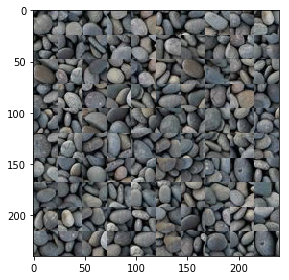

In [69]:
im_quilt= quilt_random(im,240,24)
skio.imshow(im_quilt)

# 2)Overlap Sampling

# Helper functions

In [70]:
def generate_random_patch(sample, patch_size):
    # Assuming square sample
    im_size_x = sample.size[0]
    im_size_y = sample.size[1]
    rand_x = random.randint(patchsize, im_size_x - patchsize)
    rand_y = random.randint(patchsize, im_size_y - patchsize)
    direction_list = [-1, 1]
    # After chosing a point do we go left or right for sample direction
    x_direction = random.choice(direction_list)
    # After chosing a point and left or right do we go up or down for sample direction
    y_direction = random.choice(direction_list)
    # Random patch based on randomly chosen point in the middle and randomly chosen x + y directions
    random_patch = sample[rand_x:rand_x + (patchsize), rand_y:rand_y + (patchsize)]
    return random_patch


def get_patches(sample, patch_size):
    all_patches = {}
    count = -1
    for i in range(sample.shape[0]):
        if sample.shape[0] - i < patch_size:
            break
        for j in range(sample.shape[1]):
            if sample.shape[1] - j < patch_size:
                continue
            count += 1
            all_patches[count] = sample[i: i + patch_size, j: j + patch_size, :]
    return all_patches


def ssd_cost(M, T, I):
    non_zero_I = np.zeros(I.shape)
    non_zero_I[:, :, 0], non_zero_I[:, :, 1], non_zero_I[:, :, 2] = M * I[:, :, 0], M * I[:, :, 1], M * I[:, :, 2]
    return np.sum((T - non_zero_I) ** 2)


def choose_sample(sample, patch_size, M, T, tol, all_patches):
    #Proportion of samples to sample
    proportion = 0.1
    cost_image = {}
    number = len(all_patches)
    index = np.random.choice(number, int(proportion * number))
    for i in index:
        cost_image[i] = ssd_cost(M, T, all_patches[i])
    # Calculate min SSD
    min_value = min(cost_image.values())
    within_tol = []
    for key in cost_image.keys():
        #If patch is within tolerance
        if cost_image[key] <= min_value * (1 + tol):
            within_tol.append(all_patches[key])
    # Randomly choose a patch within tolerance
    return within_tol[np.random.choice(len(within_tol))]


def impose_sample(row_pixel, column_pixel, overlap, patch_size, new_sample, sample):

    # No overlap
    if row_pixel == 0 and column_pixel == 0:
        sample[row_pixel: row_pixel + patch_size, column_pixel: column_pixel + patch_size] = new_sample
    # Only vertical overlap
    elif column_pixel == 0 and row_pixel != 0:
        sample[row_pixel + overlap // 2: row_pixel + patch_size, column_pixel: column_pixel + patch_size] = new_sample[overlap // 2:, :, :]
    # Only Horizontal overlap
    elif column_pixel != 0 and row_pixel == 0:

        sample[row_pixel: row_pixel + patch_size, column_pixel + overlap // 2: column_pixel + patch_size] = new_sample[:, overlap // 2:, :]
    # Both Vertical + Horizontal
    else:
        sample[row_pixel + overlap // 2: row_pixel + patch_size, column_pixel + overlap // 2: column_pixel + patch_size] = new_sample[overlap // 2:,
                                                                                     overlap // 2:, :]




# Overlap function

In [71]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    # Overlap cannot be bigger than patch  size
    output_image = np.zeros([out_size, out_size, 3])
    assert overlap < patch_size
    sample = sample.copy() / 255.0
    # get all possible patches from sample of size patch_size
    patches = get_patches(sample, patch_size)
    skip_size = patch_size - overlap
    for row_pixel_number in range(0, out_size + 1, skip_size):
        # Not enough space- have overshot
        if out_size - row_pixel_number < patch_size:
            break
        for column_pixel_number in range(0, out_size + 1, skip_size):
            # Not enough space- have overshot
            if out_size - column_pixel_number < patch_size:
                continue
            # Top left sample so randomly select any sample to start us off
            if row_pixel_number == 0 and column_pixel_number == 0:
                index = np.random.choice(len(patches))
                random_choice=patches[index]
                impose_sample(row_pixel_number, column_pixel_number, overlap, patch_size, random_choice, output_image)
            mask = (output_image[row_pixel_number: row_pixel_number + patch_size, column_pixel_number: column_pixel_number + patch_size, 0] != 0).astype(int)
            curr_image = (output_image[row_pixel_number: row_pixel_number + patch_size, column_pixel_number: column_pixel_number + patch_size])
            # Choose appropriate sample with tolerance parameter(Random sample within tolerance*mincost of mincost sample
            new_sample = choose_sample(sample, patch_size, mask, curr_image, tol, patches)
            # Add chosen sample to output_image
            impose_sample(row_pixel_number, column_pixel_number, overlap, patch_size, new_sample, output_image)
    return output_image

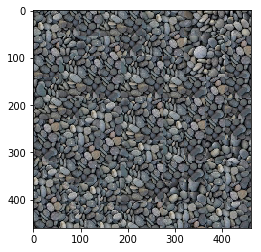

In [72]:
brick_simple = quilt_simple(im, 480, 64, 20, 0.01)
plt.imshow(brick_simple[:-20,:-20,:])                  

In [73]:
np.multiply

<ufunc 'multiply'>

# 3 Seam Finding

# Helper Functions

In [74]:
import numpy as np
from utils import *
# Got python equivalent code of Cut.m from online Taken from Internet as vut.m was already provided to us
def cut(err_patch):
    
    # create padding on top and bottom with very large cost
    padding = np.expand_dims(np.ones(err_patch.shape[1]).T*1e10,0)
    err_patch = np.concatenate((padding, err_patch, padding), axis=0)
    h, w = err_patch.shape
    path = np.zeros([h,w], dtype="int")
    cost = np.zeros([h,w])
    cost[:,0] = err_patch[:, 0]
    cost[0,:] = err_patch[0, :]
    cost[cost.shape[0]-1,:] = err_patch[err_patch.shape[0]-1, :]
    
    # for each column, compute the cheapest connected path to the left
    # cost of path for each row from left upper/same/lower pixel
    for x in range(1,w):
        # cost of path for each row from left upper/same/lower pixel
        tmp = np.vstack((cost[0:h-2,x-1], cost[1:h-1, x-1], cost[2:h, x-1]))
        mi = tmp.argmin(axis=0)
        path[1:h-1, x] = np.arange(1, h-1, 1).T + mi # save the next step of the path
        cost[1:h-1, x] = cost[path[1:h-1, x] - 1, x-1] + err_patch[1:h-1, x]

    path = path[1:path.shape[0]-1, :] - 1
    cost = cost[1:cost.shape[0]-1, :]
    
    # create the mask based on the best path
    mask = np.zeros(path.shape, dtype="int")
    best_path = np.zeros(path.shape[1], dtype="int")
    best_path[len(best_path)-1] = np.argmin(cost[:, cost.shape[1]-1]) + 1
    mask[0:best_path[best_path.shape[0]-1], mask.shape[1]-1] = 1
    for x in range(best_path.size-1, 0, -1):
        best_path[x-1] = path[best_path[x]-1, x]
        mask[:best_path[x-1], x-1] = 1
    mask ^= 1
    return mask

def get_horizontal_mask(cost, overlap):
    template = cost[:, 0 : overlap]
    return cut(template.T).T
    
def get_vertical_mask(cost, overlap):
    template = cost[0 : overlap, :]
    return cut(template)

def ssd_patch(M, T, I):
    
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [75]:
def fill_h(i, j, patch_size, overlap, mask, rgb_output, rgb_sample):
    overlap_rgb = rgb_output[i : i + patch_size, j : j + overlap, :]

    for k in range(3):
        overlap_rgb[:,:,k] =  rgb_sample[:,:overlap,k] * mask  + (1 - mask) * overlap_rgb[:,:,k]



def fill_v(i, j, patch_size, overlap, mask, rgb_output, rgb_sample):
    overlap_rgb = rgb_output[i : i + overlap, j : j + patch_size, :]
    for k in range(3):
        overlap_rgb[:,:,k] =  rgb_sample[:overlap,:,k] * mask  + (1 - mask) * overlap_rgb[:,:,k]


def fill_left_h(i, j, patch_size, overlap, rgb_output, rgb_sample):
    rgb_output[i : i + patch_size, j + overlap : j + patch_size,:] = rgb_sample[:, overlap:,:]

def fill_left_v(i, j, patch_size, overlap, rgb_output, rgb_sample):
    rgb_output[i + overlap : i + patch_size, j : j + patch_size,:] = rgb_sample[overlap:, :,:]

def fill_left(i, j, patch_size, overlap, rgb_output, rgb_sample):
    rgb_output[i + overlap : i + patch_size, j + overlap : j + patch_size,:] = rgb_sample[overlap:, overlap:,:]

In [76]:
def get_patches(sample, patch_size):
    all_patches = {}
    count = -1
    for i in range(sample.shape[0]):
        if sample.shape[0] - i < patch_size:
            break
        for j in range(sample.shape[1]):
            if sample.shape[1] - j < patch_size:
                continue
            count += 1
            all_patches[count] = sample[i: i + patch_size, j: j + patch_size, :]
    return all_patches


def ssd_cost(M, T, I):
    # return one channel
    useful_I = np.zeros(I.shape)
    useful_I[:, :, 0], useful_I[:, :, 1], useful_I[:, :, 2] = M * I[:, :, 0], M * I[:, :, 1], M * I[:, :, 2]
    return np.sum((T - useful_I) ** 2, -1)


def choose_seam_sample(sample, patch_size, M, T, tol, all_patches):
    proportion = 0.1
    cost = {}
    cost_image = {}
    n = len(all_patches)
    # take prop* n samples
    index = np.random.choice(n, int(proportion * n))

    for i in index:
        temp_cost = ssd_cost(M, T, all_patches[i])
        cost[i] = np.sum(temp_cost)
        cost_image[i] = temp_cost

    min_value = min(cost.values())
    within_tol = []
    cost_images = []
    for key in cost_image.keys():
        if cost[key] <= min_value * (1 + tol):
            within_tol.append(all_patches[key])
            cost_images.append(cost_image[key])

    index = np.random.choice(len(within_tol))
    return within_tol[index], cost_images[index]

In [77]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    sample = sample.copy() / 255.0
    patches = get_patches(sample, patch_size)
    skip_size = patch_size - overlap
    output_image = np.zeros([out_size, out_size, 3])

    for row_pixel in range(0, out_size + 1, skip_size):
        # Overshot vertically
        if out_size - row_pixel < patch_size:
            break
        for column_pixel in range(0, out_size + 1, skip_size):
            print(row_pixel, column_pixel)
            # Overshot Horizontally
            if out_size - column_pixel < patch_size:
                continue
            M = (output_image[row_pixel: row_pixel + patch_size, column_pixel: column_pixel + patch_size, 0] != 0)
            T = (output_image[row_pixel: row_pixel + patch_size, column_pixel: column_pixel + patch_size, :])
            # New choose sample_function
            new_sample, cost = choose_seam_sample(sample, patch_size, M, T, tol, patches)

            if row_pixel == 0 and column_pixel == 0:
                index = np.random.choice(len(patches))
                impose_sample(row_pixel, column_pixel, overlap, patch_size, patches[index], output_image)



            elif row_pixel == 0 and column_pixel != 0:
                mask = get_horizontal_mask(cost, overlap)
                fill_h(row_pixel, column_pixel, patch_size, overlap, mask, output_image, new_sample)
                fill_left_h(row_pixel, column_pixel, patch_size, overlap, output_image, new_sample)

                
                
                
            elif row_pixel != 0 and column_pixel == 0:
                mask = get_vertical_mask(cost, overlap)
                fill_v(row_pixel, column_pixel, patch_size, overlap, mask, output_image, new_sample)
                fill_left_v(row_pixel, column_pixel, patch_size, overlap, output_image, new_sample)

            else:
                mask = get_horizontal_mask(cost, overlap)
                fill_h(row_pixel, column_pixel, patch_size, overlap, mask, output_image, new_sample)
                cost = ssd_cost(M, T, new_sample)
                mask = get_vertical_mask(cost, overlap)
                fill_v(row_pixel, column_pixel, patch_size, overlap, mask, output_image, new_sample)
                fill_left(row_pixel, column_pixel, patch_size, overlap, output_image, new_sample)

    return output_image

0 0
0 55
0 110
0 165
0 220
0 275
0 330
0 385
0 440
55 0
55 55
55 110
55 165
55 220
55 275
55 330
55 385
55 440
110 0
110 55
110 110
110 165
110 220
110 275
110 330
110 385
110 440
165 0
165 55
165 110
165 165
165 220
165 275
165 330
165 385
165 440
220 0
220 55
220 110
220 165
220 220
220 275
220 330
220 385
220 440
275 0
275 55
275 110
275 165
275 220
275 275
275 330
275 385
275 440
330 0
330 55
330 110
330 165
330 220
330 275
330 330
330 385
330 440
385 0
385 55
385 110
385 165
385 220
385 275
385 330
385 385
385 440


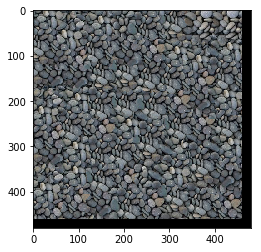

In [78]:
objects = quilt_cut(im, 480, 75, 20, 0.005)
plt.imshow(objects)

# 4 Texture Transfer

In [49]:
                    
def ssd_cost(M, T, I):
    useful_I = np.zeros(I.shape)
    useful_I[:,:,0], useful_I[:,:,1], useful_I[:,:,2] = M * I[:,:,0], M * I[:,:,1], M * I[:,:,2]
    return np.sum((T - useful_I) ** 2, -1)

    
def choose_sample_p4(patch_size, M, T, tol, target, all_patches):
#     cost_image = np.zeros([sample.shape[0] - patch_size, sample.shape[0]- patch_size])
    proportion = 0.05
    cost = {}
    cost_image = {}
    n = len(all_patches)
    index = np.random.choice(n, int(proportion * n))

    for i in index:
        alpha = np.sum(M) / (M.shape[0] * M.shape[1])
        temp_cost = ssd_cost(M, T, all_patches[i])
        cost2 = ssd_cost(np.ones([patch_size, patch_size]), target, all_patches[i])
        cost[i] = alpha * np.sum(temp_cost) + (1 - alpha) * np.sum(cost2)
        cost_image[i] = temp_cost
    
    min_value = min(cost.values())
    choices = []
    cost_images = []
    for key in cost_image.keys():
        if cost[key] <= min_value * (1 + tol):
            choices.append(all_patches[key])
            cost_images.append(cost_image[key])
    
    index = np.random.choice(len(choices))
    return choices[index], cost_images[index] 
              
    
    
def texture_transfer(texture, target, patch_size, overlap, tol):
    """
    Feel free to add function parameters
    """
    texture = texture.copy() / 255.0
    step = patch_size - overlap
    output = target.copy() / 255.0
    patches = get_patches(texture, patch_size)
    
    
    for i in range(0, target.shape[0] + 1, step):
        if target.shape[0] - i < patch_size:
            break
        for j in range(0, target.shape[1] + 1, step):
            print(i, j)
            if target.shape[1] - j < patch_size:
                continue
            M = (output[i : i + patch_size, j : j + patch_size, 0] != 0).astype(int)
            T = (output[i : i + patch_size, j : j + patch_size, :])
            rgb_texture_sample, cost = choose_sample_p4(patch_size, M, T,\
                                                                     tol, output[i:i + patch_size, j : j + patch_size], patches)
            if i == 0 and j == 0:
                impose_sample(i, j, overlap, patch_size, rgb_texture_sample, output)
                
            elif i == 0 and j != 0:
                mask = get_horizontal_mask(cost, overlap)
                fill_h(i, j, patch_size, overlap, mask, output,rgb_texture_sample)
                fill_left_h(i, j, patch_size, overlap, output, rgb_texture_sample)
                
            elif i != 0 and j == 0:
                mask = get_vertical_mask(cost, overlap)
                fill_v(i, j, patch_size, overlap, mask, output, rgb_texture_sample)
                fill_left_v(i, j, patch_size, overlap, output, rgb_texture_sample)
                
            else:
                mask = get_horizontal_mask(cost, overlap)
                fill_h(i, j, patch_size, overlap, mask, output, rgb_texture_sample)  
                cost = ssd_cost(M, T, rgb_texture_sample)
                mask = get_vertical_mask(cost, overlap)
                fill_v(i, j, patch_size, overlap, mask, output, rgb_texture_sample)
                fill_left(i, j, patch_size, overlap, output, rgb_texture_sample)
                

    return output

In [58]:
def texture_transfer(texture, target, patch_size, overlap, tol):
    # Create copies
    texture = texture.copy() / 255.0
    skip_size = patch_size - overlap
    output = target.copy() / 255.0
    patches = get_patches(texture, patch_size)

    for row_pixel in range(0, target.shape[0] + 1, skip_size):
        # Horizontal overshoot
        if target.shape[0] - row_pixel < patch_size:
            break
        for column_pixel in range(0, target.shape[1] + 1, skip_size):
            print(row_pixel, column_pixel)
            if target.shape[1] - column_pixel < patch_size:
                continue
            M = (output[row_pixel: row_pixel + patch_size, column_pixel: column_pixel + patch_size, 0] != 0).astype(int)
            T = (output[row_pixel: row_pixel + patch_size, column_pixel: column_pixel + patch_size, :])
            rgb_texture_sample, cost = choose_sample_texture_transfer(patch_size, M, T, \
                                                                      tol, output[row_pixel:row_pixel + patch_size, column_pixel: column_pixel + patch_size], patches)
            # Initialize a patch if no patch there
            if row_pixel == 0 and column_pixel == 0:
                impose_sample(row_pixel, column_pixel, overlap, patch_size, rgb_texture_sample, output)
            elif row_pixel != 0 and column_pixel == 0:
                mask = get_vertical_mask(cost, overlap)
                fill_v(row_pixel, column_pixel, patch_size, overlap, mask, output, rgb_texture_sample)
                fill_left_v(row_pixel, column_pixel, patch_size, overlap, output, rgb_texture_sample)

            elif row_pixel == 0 and column_pixel != 0:
                mask = get_horizontal_mask(cost, overlap)
                fill_h(row_pixel, column_pixel, patch_size, overlap, mask, output, rgb_texture_sample)
                fill_left_h(row_pixel, column_pixel, patch_size, overlap, output, rgb_texture_sample)

            else:
                mask = get_horizontal_mask(cost, overlap)
                fill_h(row_pixel, column_pixel, patch_size, overlap, mask, output, rgb_texture_sample)
                cost = ssd_cost(M, T, rgb_texture_sample)
                mask = get_vertical_mask(cost, overlap)
                fill_v(row_pixel, column_pixel, patch_size, overlap, mask, output, rgb_texture_sample)
                fill_left(row_pixel, column_pixel, patch_size, overlap, output, rgb_texture_sample)

    return output


def choose_sample_texture_transfer(patch_size, mask, T, tol, target, all_patches):
    #     cost_image = np.zeros([sample.shape[0] - patch_size, sample.shape[0]- patch_size])
    prop = 0.05
    cost = {}
    cost_image = {}
    n = len(all_patches)
    index = np.random.choice(n, int(prop * n))
     #iterate over every item in sample
    for i in index:
        # This is the algorithm discussed in the paper
        alpha_val = np.sum(mask) / (mask.shape[0] * mask.shape[1])
        temp_cost = ssd_cost(mask, T, all_patches[i])
        cost2 = ssd_cost(np.ones([patch_size, patch_size]), target, all_patches[i])
        cost[i] = alpha_val * np.sum(temp_cost) + (1 - alpha_val) * np.sum(cost2)
        cost_image[i] = temp_cost

    min_value = min(cost.values())
    
    
    
    
    
    
    within_tol = []
    cost_images = []
    
    
    for key in cost_image.keys():
        if cost[key] <= min_value * (1 + tol):
            within_tol.append(all_patches[key])
            cost_images.append(cost_image[key])

    # return random sample within tol as always
    index = np.random.choice(len(within_tol))
    return within_tol[index], cost_images[index] 

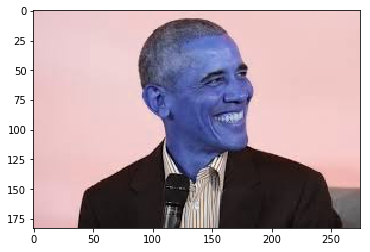

In [59]:
obj = cv2.imread("obama.jpg")
plt.imshow(obj)
plt.show()

(250, 250, 3)


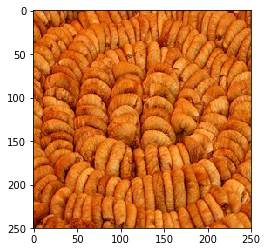

In [60]:
texture = cv2.imread("fig.jpg")
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
print(texture.shape)
plt.imshow(texture)
plt.show()

In [61]:
toast_man = texture_transfer(texture, target, 11, 3, 0.1)

0 0
0 8
0 16
0 24
0 32
0 40
0 48
0 56
0 64
0 72
0 80
0 88
0 96
0 104
0 112
0 120
0 128
0 136
0 144
0 152
0 160
0 168
0 176
0 184
0 192
0 200
0 208
0 216
0 224
0 232
0 240
0 248
0 256
0 264
0 272
8 0
8 8
8 16
8 24
8 32
8 40
8 48
8 56
8 64
8 72
8 80
8 88
8 96
8 104
8 112
8 120
8 128
8 136
8 144
8 152
8 160
8 168
8 176
8 184
8 192
8 200
8 208
8 216
8 224
8 232
8 240
8 248
8 256
8 264
8 272
16 0
16 8
16 16
16 24
16 32
16 40
16 48
16 56
16 64
16 72
16 80
16 88
16 96
16 104
16 112
16 120
16 128
16 136
16 144
16 152
16 160
16 168
16 176
16 184
16 192
16 200
16 208
16 216
16 224
16 232
16 240
16 248
16 256
16 264
16 272
24 0
24 8
24 16
24 24
24 32
24 40
24 48
24 56
24 64
24 72
24 80
24 88
24 96
24 104
24 112
24 120
24 128
24 136
24 144
24 152
24 160
24 168
24 176
24 184
24 192
24 200
24 208
24 216
24 224
24 232
24 240
24 248
24 256
24 264
24 272
32 0
32 8
32 16
32 24
32 32
32 40
32 48
32 56
32 64
32 72
32 80
32 88
32 96
32 104
32 112
32 120
32 128
32 136
32 144
32 152
32 160
32 168
32 176
32 1

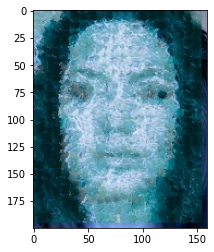

In [171]:
plt.imshow(toast_man)

In [31]:
avik_pasta = texture_transfer(texture, target_2, 11, 3, 0.1)

0 0
0 8
0 16
0 24
0 32
0 40
0 48
0 56
0 64
0 72
0 80
0 88
0 96
0 104
0 112
0 120
0 128
0 136
0 144
0 152
0 160
0 168
0 176
0 184
0 192
0 200
0 208
0 216
0 224
0 232
0 240
0 248
0 256
0 264
0 272
0 280
0 288
0 296
0 304
0 312
0 320
0 328
0 336
0 344
0 352
0 360
0 368
0 376
0 384
0 392
0 400
0 408
0 416
0 424
0 432
0 440
0 448
0 456
0 464
0 472
0 480
0 488
0 496
0 504
0 512
0 520
0 528
0 536
0 544
0 552
0 560
0 568
0 576
0 584
0 592
0 600
0 608
0 616
0 624
0 632
0 640
0 648
0 656
0 664
0 672
0 680
0 688
0 696
0 704
0 712
0 720
0 728
0 736
0 744
0 752
0 760
0 768
0 776
0 784
0 792
0 800
0 808
0 816
0 824
0 832
0 840
0 848
0 856
0 864
0 872
0 880
0 888
0 896
0 904
0 912
0 920
0 928
0 936
0 944
0 952
0 960
0 968
8 0
8 8
8 16
8 24
8 32
8 40
8 48
8 56
8 64
8 72
8 80
8 88
8 96
8 104
8 112
8 120
8 128
8 136
8 144
8 152
8 160
8 168
8 176
8 184
8 192
8 200
8 208
8 216
8 224
8 232
8 240
8 248
8 256
8 264
8 272
8 280
8 288
8 296
8 304
8 312
8 320
8 328
8 336
8 344
8 352
8 360
8 368
8 376
8 384
8 39

80 72
80 80
80 88
80 96
80 104
80 112
80 120
80 128
80 136
80 144
80 152
80 160
80 168
80 176
80 184
80 192
80 200
80 208
80 216
80 224
80 232
80 240
80 248
80 256
80 264
80 272
80 280
80 288
80 296
80 304
80 312
80 320
80 328
80 336
80 344
80 352
80 360
80 368
80 376
80 384
80 392
80 400
80 408
80 416
80 424
80 432
80 440
80 448
80 456
80 464
80 472
80 480
80 488
80 496
80 504
80 512
80 520
80 528
80 536
80 544
80 552
80 560
80 568
80 576
80 584
80 592
80 600
80 608
80 616
80 624
80 632
80 640
80 648
80 656
80 664
80 672
80 680
80 688
80 696
80 704
80 712
80 720
80 728
80 736
80 744
80 752
80 760
80 768
80 776
80 784
80 792
80 800
80 808
80 816
80 824
80 832
80 840
80 848
80 856
80 864
80 872
80 880
80 888
80 896
80 904
80 912
80 920
80 928
80 936
80 944
80 952
80 960
80 968
88 0
88 8
88 16
88 24
88 32
88 40
88 48
88 56
88 64
88 72
88 80
88 88
88 96
88 104
88 112
88 120
88 128
88 136
88 144
88 152
88 160
88 168
88 176
88 184
88 192
88 200
88 208
88 216
88 224
88 232
88 240
88 248
88 2

144 944
144 952
144 960
144 968
152 0
152 8
152 16
152 24
152 32
152 40
152 48
152 56
152 64
152 72
152 80
152 88
152 96
152 104
152 112
152 120
152 128
152 136
152 144
152 152
152 160
152 168
152 176
152 184
152 192
152 200
152 208
152 216
152 224
152 232
152 240
152 248
152 256
152 264
152 272
152 280
152 288
152 296
152 304
152 312
152 320
152 328
152 336
152 344
152 352
152 360
152 368
152 376
152 384
152 392
152 400
152 408
152 416
152 424
152 432
152 440
152 448
152 456
152 464
152 472
152 480
152 488
152 496
152 504
152 512
152 520
152 528
152 536
152 544
152 552
152 560
152 568
152 576
152 584
152 592
152 600
152 608
152 616
152 624
152 632
152 640
152 648
152 656
152 664
152 672
152 680
152 688
152 696
152 704
152 712
152 720
152 728
152 736
152 744
152 752
152 760
152 768
152 776
152 784
152 792
152 800
152 808
152 816
152 824
152 832
152 840
152 848
152 856
152 864
152 872
152 880
152 888
152 896
152 904
152 912
152 920
152 928
152 936
152 944
152 952
152 960
152 968
160 0
1

216 488
216 496
216 504
216 512
216 520
216 528
216 536
216 544
216 552
216 560
216 568
216 576
216 584
216 592
216 600
216 608
216 616
216 624
216 632
216 640
216 648
216 656
216 664
216 672
216 680
216 688
216 696
216 704
216 712
216 720
216 728
216 736
216 744
216 752
216 760
216 768
216 776
216 784
216 792
216 800
216 808
216 816
216 824
216 832
216 840
216 848
216 856
216 864
216 872
216 880
216 888
216 896
216 904
216 912
216 920
216 928
216 936
216 944
216 952
216 960
216 968
224 0
224 8
224 16
224 24
224 32
224 40
224 48
224 56
224 64
224 72
224 80
224 88
224 96
224 104
224 112
224 120
224 128
224 136
224 144
224 152
224 160
224 168
224 176
224 184
224 192
224 200
224 208
224 216
224 224
224 232
224 240
224 248
224 256
224 264
224 272
224 280
224 288
224 296
224 304
224 312
224 320
224 328
224 336
224 344
224 352
224 360
224 368
224 376
224 384
224 392
224 400
224 408
224 416
224 424
224 432
224 440
224 448
224 456
224 464
224 472
224 480
224 488
224 496
224 504
224 512
224 520

288 24
288 32
288 40
288 48
288 56
288 64
288 72
288 80
288 88
288 96
288 104
288 112
288 120
288 128
288 136
288 144
288 152
288 160
288 168
288 176
288 184
288 192
288 200
288 208
288 216
288 224
288 232
288 240
288 248
288 256
288 264
288 272
288 280
288 288
288 296
288 304
288 312
288 320
288 328
288 336
288 344
288 352
288 360
288 368
288 376
288 384
288 392
288 400
288 408
288 416
288 424
288 432
288 440
288 448
288 456
288 464
288 472
288 480
288 488
288 496
288 504
288 512
288 520
288 528
288 536
288 544
288 552
288 560
288 568
288 576
288 584
288 592
288 600
288 608
288 616
288 624
288 632
288 640
288 648
288 656
288 664
288 672
288 680
288 688
288 696
288 704
288 712
288 720
288 728
288 736
288 744
288 752
288 760
288 768
288 776
288 784
288 792
288 800
288 808
288 816
288 824
288 832
288 840
288 848
288 856
288 864
288 872
288 880
288 888
288 896
288 904
288 912
288 920
288 928
288 936
288 944
288 952
288 960
288 968
296 0
296 8
296 16
296 24
296 32
296 40
296 48
296 56
296 

352 544
352 552
352 560
352 568
352 576
352 584
352 592
352 600
352 608
352 616
352 624
352 632
352 640
352 648
352 656
352 664
352 672
352 680
352 688
352 696
352 704
352 712
352 720
352 728
352 736
352 744
352 752
352 760
352 768
352 776
352 784
352 792
352 800
352 808
352 816
352 824
352 832
352 840
352 848
352 856
352 864
352 872
352 880
352 888
352 896
352 904
352 912
352 920
352 928
352 936
352 944
352 952
352 960
352 968
360 0
360 8
360 16
360 24
360 32
360 40
360 48
360 56
360 64
360 72
360 80
360 88
360 96
360 104
360 112
360 120
360 128
360 136
360 144
360 152
360 160
360 168
360 176
360 184
360 192
360 200
360 208
360 216
360 224
360 232
360 240
360 248
360 256
360 264
360 272
360 280
360 288
360 296
360 304
360 312
360 320
360 328
360 336
360 344
360 352
360 360
360 368
360 376
360 384
360 392
360 400
360 408
360 416
360 424
360 432
360 440
360 448
360 456
360 464
360 472
360 480
360 488
360 496
360 504
360 512
360 520
360 528
360 536
360 544
360 552
360 560
360 568
360 576

424 88
424 96
424 104
424 112
424 120
424 128
424 136
424 144
424 152
424 160
424 168
424 176
424 184
424 192
424 200
424 208
424 216
424 224
424 232
424 240
424 248
424 256
424 264
424 272
424 280
424 288
424 296
424 304
424 312
424 320
424 328
424 336
424 344
424 352
424 360
424 368
424 376
424 384
424 392
424 400
424 408
424 416
424 424
424 432
424 440
424 448
424 456
424 464
424 472
424 480
424 488
424 496
424 504
424 512
424 520
424 528
424 536
424 544
424 552
424 560
424 568
424 576
424 584
424 592
424 600
424 608
424 616
424 624
424 632
424 640
424 648
424 656
424 664
424 672
424 680
424 688
424 696
424 704
424 712
424 720
424 728
424 736
424 744
424 752
424 760
424 768
424 776
424 784
424 792
424 800
424 808
424 816
424 824
424 832
424 840
424 848
424 856
424 864
424 872
424 880
424 888
424 896
424 904
424 912
424 920
424 928
424 936
424 944
424 952
424 960
424 968
432 0
432 8
432 16
432 24
432 32
432 40
432 48
432 56
432 64
432 72
432 80
432 88
432 96
432 104
432 112
432 120
4

488 600
488 608
488 616
488 624
488 632
488 640
488 648
488 656
488 664
488 672
488 680
488 688
488 696
488 704
488 712
488 720
488 728
488 736
488 744
488 752
488 760
488 768
488 776
488 784
488 792
488 800
488 808
488 816
488 824
488 832
488 840
488 848
488 856
488 864
488 872
488 880
488 888
488 896
488 904
488 912
488 920
488 928
488 936
488 944
488 952
488 960
488 968
496 0
496 8
496 16
496 24
496 32
496 40
496 48
496 56
496 64
496 72
496 80
496 88
496 96
496 104
496 112
496 120
496 128
496 136
496 144
496 152
496 160
496 168
496 176
496 184
496 192
496 200
496 208
496 216
496 224
496 232
496 240
496 248
496 256
496 264
496 272
496 280
496 288
496 296
496 304
496 312
496 320
496 328
496 336
496 344
496 352
496 360
496 368
496 376
496 384
496 392
496 400
496 408
496 416
496 424
496 432
496 440
496 448
496 456
496 464
496 472
496 480
496 488
496 496
496 504
496 512
496 520
496 528
496 536
496 544
496 552
496 560
496 568
496 576
496 584
496 592
496 600
496 608
496 616
496 624
496 632

560 144
560 152
560 160
560 168
560 176
560 184
560 192
560 200
560 208
560 216
560 224
560 232
560 240
560 248
560 256
560 264
560 272
560 280
560 288
560 296
560 304
560 312
560 320
560 328
560 336
560 344
560 352
560 360
560 368
560 376
560 384
560 392
560 400
560 408
560 416
560 424
560 432
560 440
560 448
560 456
560 464
560 472
560 480
560 488
560 496
560 504
560 512
560 520
560 528
560 536
560 544
560 552
560 560
560 568
560 576
560 584
560 592
560 600
560 608
560 616
560 624
560 632
560 640
560 648
560 656
560 664
560 672
560 680
560 688
560 696
560 704
560 712
560 720
560 728
560 736
560 744
560 752
560 760
560 768
560 776
560 784
560 792
560 800
560 808
560 816
560 824
560 832
560 840
560 848
560 856
560 864
560 872
560 880
560 888
560 896
560 904
560 912
560 920
560 928
560 936
560 944
560 952
560 960
560 968
568 0
568 8
568 16
568 24
568 32
568 40
568 48
568 56
568 64
568 72
568 80
568 88
568 96
568 104
568 112
568 120
568 128
568 136
568 144
568 152
568 160
568 168
568 176

624 656
624 664
624 672
624 680
624 688
624 696
624 704
624 712
624 720
624 728
624 736
624 744
624 752
624 760
624 768
624 776
624 784
624 792
624 800
624 808
624 816
624 824
624 832
624 840
624 848
624 856
624 864
624 872
624 880
624 888
624 896
624 904
624 912
624 920
624 928
624 936
624 944
624 952
624 960
624 968
632 0
632 8
632 16
632 24
632 32
632 40
632 48
632 56
632 64
632 72
632 80
632 88
632 96
632 104
632 112
632 120
632 128
632 136
632 144
632 152
632 160
632 168
632 176
632 184
632 192
632 200
632 208
632 216
632 224
632 232
632 240
632 248
632 256
632 264
632 272
632 280
632 288
632 296
632 304
632 312
632 320
632 328
632 336
632 344
632 352
632 360
632 368
632 376
632 384
632 392
632 400
632 408
632 416
632 424
632 432
632 440
632 448
632 456
632 464
632 472
632 480
632 488
632 496
632 504
632 512
632 520
632 528
632 536
632 544
632 552
632 560
632 568
632 576
632 584
632 592
632 600
632 608
632 616
632 624
632 632
632 640
632 648
632 656
632 664
632 672
632 680
632 688

696 200
696 208
696 216
696 224
696 232
696 240
696 248
696 256
696 264
696 272
696 280
696 288
696 296
696 304
696 312
696 320
696 328
696 336
696 344
696 352
696 360
696 368
696 376
696 384
696 392
696 400
696 408
696 416
696 424
696 432
696 440
696 448
696 456
696 464
696 472
696 480
696 488
696 496
696 504
696 512
696 520
696 528
696 536
696 544
696 552
696 560
696 568
696 576
696 584
696 592
696 600
696 608
696 616
696 624
696 632
696 640
696 648
696 656
696 664
696 672
696 680
696 688
696 696
696 704
696 712
696 720
696 728
696 736
696 744
696 752
696 760
696 768
696 776
696 784
696 792
696 800
696 808
696 816
696 824
696 832
696 840
696 848
696 856
696 864
696 872
696 880
696 888
696 896
696 904
696 912
696 920
696 928
696 936
696 944
696 952
696 960
696 968
704 0
704 8
704 16
704 24
704 32
704 40
704 48
704 56
704 64
704 72
704 80
704 88
704 96
704 104
704 112
704 120
704 128
704 136
704 144
704 152
704 160
704 168
704 176
704 184
704 192
704 200
704 208
704 216
704 224
704 232

760 712
760 720
760 728
760 736
760 744
760 752
760 760
760 768
760 776
760 784
760 792
760 800
760 808
760 816
760 824
760 832
760 840
760 848
760 856
760 864
760 872
760 880
760 888
760 896
760 904
760 912
760 920
760 928
760 936
760 944
760 952
760 960
760 968
768 0
768 8
768 16
768 24
768 32
768 40
768 48
768 56
768 64
768 72
768 80
768 88
768 96
768 104
768 112
768 120
768 128
768 136
768 144
768 152
768 160
768 168
768 176
768 184
768 192
768 200
768 208
768 216
768 224
768 232
768 240
768 248
768 256
768 264
768 272
768 280
768 288
768 296
768 304
768 312
768 320
768 328
768 336
768 344
768 352
768 360
768 368
768 376
768 384
768 392
768 400
768 408
768 416
768 424
768 432
768 440
768 448
768 456
768 464
768 472
768 480
768 488
768 496
768 504
768 512
768 520
768 528
768 536
768 544
768 552
768 560
768 568
768 576
768 584
768 592
768 600
768 608
768 616
768 624
768 632
768 640
768 648
768 656
768 664
768 672
768 680
768 688
768 696
768 704
768 712
768 720
768 728
768 736
768 744

832 256
832 264
832 272
832 280
832 288
832 296
832 304
832 312
832 320
832 328
832 336
832 344
832 352
832 360
832 368
832 376
832 384
832 392
832 400
832 408
832 416
832 424
832 432
832 440
832 448
832 456
832 464
832 472
832 480
832 488
832 496
832 504
832 512
832 520
832 528
832 536
832 544
832 552
832 560
832 568
832 576
832 584
832 592
832 600
832 608
832 616
832 624
832 632
832 640
832 648
832 656
832 664
832 672
832 680
832 688
832 696
832 704
832 712
832 720
832 728
832 736
832 744
832 752
832 760
832 768
832 776
832 784
832 792
832 800
832 808
832 816
832 824
832 832
832 840
832 848
832 856
832 864
832 872
832 880
832 888
832 896
832 904
832 912
832 920
832 928
832 936
832 944
832 952
832 960
832 968
840 0
840 8
840 16
840 24
840 32
840 40
840 48
840 56
840 64
840 72
840 80
840 88
840 96
840 104
840 112
840 120
840 128
840 136
840 144
840 152
840 160
840 168
840 176
840 184
840 192
840 200
840 208
840 216
840 224
840 232
840 240
840 248
840 256
840 264
840 272
840 280
840 288

896 768
896 776
896 784
896 792
896 800
896 808
896 816
896 824
896 832
896 840
896 848
896 856
896 864
896 872
896 880
896 888
896 896
896 904
896 912
896 920
896 928
896 936
896 944
896 952
896 960
896 968
904 0
904 8
904 16
904 24
904 32
904 40
904 48
904 56
904 64
904 72
904 80
904 88
904 96
904 104
904 112
904 120
904 128
904 136
904 144
904 152
904 160
904 168
904 176
904 184
904 192
904 200
904 208
904 216
904 224
904 232
904 240
904 248
904 256
904 264
904 272
904 280
904 288
904 296
904 304
904 312
904 320
904 328
904 336
904 344
904 352
904 360
904 368
904 376
904 384
904 392
904 400
904 408
904 416
904 424
904 432
904 440
904 448
904 456
904 464
904 472
904 480
904 488
904 496
904 504
904 512
904 520
904 528
904 536
904 544
904 552
904 560
904 568
904 576
904 584
904 592
904 600
904 608
904 616
904 624
904 632
904 640
904 648
904 656
904 664
904 672
904 680
904 688
904 696
904 704
904 712
904 720
904 728
904 736
904 744
904 752
904 760
904 768
904 776
904 784
904 792
904 800

968 312
968 320
968 328
968 336
968 344
968 352
968 360
968 368
968 376
968 384
968 392
968 400
968 408
968 416
968 424
968 432
968 440
968 448
968 456
968 464
968 472
968 480
968 488
968 496
968 504
968 512
968 520
968 528
968 536
968 544
968 552
968 560
968 568
968 576
968 584
968 592
968 600
968 608
968 616
968 624
968 632
968 640
968 648
968 656
968 664
968 672
968 680
968 688
968 696
968 704
968 712
968 720
968 728
968 736
968 744
968 752
968 760
968 768
968 776
968 784
968 792
968 800
968 808
968 816
968 824
968 832
968 840
968 848
968 856
968 864
968 872
968 880
968 888
968 896
968 904
968 912
968 920
968 928
968 936
968 944
968 952
968 960
968 968
976 0
976 8
976 16
976 24
976 32
976 40
976 48
976 56
976 64
976 72
976 80
976 88
976 96
976 104
976 112
976 120
976 128
976 136
976 144
976 152
976 160
976 168
976 176
976 184
976 192
976 200
976 208
976 216
976 224
976 232
976 240
976 248
976 256
976 264
976 272
976 280
976 288
976 296
976 304
976 312
976 320
976 328
976 336
976 344

1032 296
1032 304
1032 312
1032 320
1032 328
1032 336
1032 344
1032 352
1032 360
1032 368
1032 376
1032 384
1032 392
1032 400
1032 408
1032 416
1032 424
1032 432
1032 440
1032 448
1032 456
1032 464
1032 472
1032 480
1032 488
1032 496
1032 504
1032 512
1032 520
1032 528
1032 536
1032 544
1032 552
1032 560
1032 568
1032 576
1032 584
1032 592
1032 600
1032 608
1032 616
1032 624
1032 632
1032 640
1032 648
1032 656
1032 664
1032 672
1032 680
1032 688
1032 696
1032 704
1032 712
1032 720
1032 728
1032 736
1032 744
1032 752
1032 760
1032 768
1032 776
1032 784
1032 792
1032 800
1032 808
1032 816
1032 824
1032 832
1032 840
1032 848
1032 856
1032 864
1032 872
1032 880
1032 888
1032 896
1032 904
1032 912
1032 920
1032 928
1032 936
1032 944
1032 952
1032 960
1032 968
1040 0
1040 8
1040 16
1040 24
1040 32
1040 40
1040 48
1040 56
1040 64
1040 72
1040 80
1040 88
1040 96
1040 104
1040 112
1040 120
1040 128
1040 136
1040 144
1040 152
1040 160
1040 168
1040 176
1040 184
1040 192
1040 200
1040 208
1040 21

1088 840
1088 848
1088 856
1088 864
1088 872
1088 880
1088 888
1088 896
1088 904
1088 912
1088 920
1088 928
1088 936
1088 944
1088 952
1088 960
1088 968
1096 0
1096 8
1096 16
1096 24
1096 32
1096 40
1096 48
1096 56
1096 64
1096 72
1096 80
1096 88
1096 96
1096 104
1096 112
1096 120
1096 128
1096 136
1096 144
1096 152
1096 160
1096 168
1096 176
1096 184
1096 192
1096 200
1096 208
1096 216
1096 224
1096 232
1096 240
1096 248
1096 256
1096 264
1096 272
1096 280
1096 288
1096 296
1096 304
1096 312
1096 320
1096 328
1096 336
1096 344
1096 352
1096 360
1096 368
1096 376
1096 384
1096 392
1096 400
1096 408
1096 416
1096 424
1096 432
1096 440
1096 448
1096 456
1096 464
1096 472
1096 480
1096 488
1096 496
1096 504
1096 512
1096 520
1096 528
1096 536
1096 544
1096 552
1096 560
1096 568
1096 576
1096 584
1096 592
1096 600
1096 608
1096 616
1096 624
1096 632
1096 640
1096 648
1096 656
1096 664
1096 672
1096 680
1096 688
1096 696
1096 704
1096 712
1096 720
1096 728
1096 736
1096 744
1096 752
1096 76

1152 424
1152 432
1152 440
1152 448
1152 456
1152 464
1152 472
1152 480
1152 488
1152 496
1152 504
1152 512
1152 520
1152 528
1152 536
1152 544
1152 552
1152 560
1152 568
1152 576
1152 584
1152 592
1152 600
1152 608
1152 616
1152 624
1152 632
1152 640
1152 648
1152 656
1152 664
1152 672
1152 680
1152 688
1152 696
1152 704
1152 712
1152 720
1152 728
1152 736
1152 744
1152 752
1152 760
1152 768
1152 776
1152 784
1152 792
1152 800
1152 808
1152 816
1152 824
1152 832
1152 840
1152 848
1152 856
1152 864
1152 872
1152 880
1152 888
1152 896
1152 904
1152 912
1152 920
1152 928
1152 936
1152 944
1152 952
1152 960
1152 968
1160 0
1160 8
1160 16
1160 24
1160 32
1160 40
1160 48
1160 56
1160 64
1160 72
1160 80
1160 88
1160 96
1160 104
1160 112
1160 120
1160 128
1160 136
1160 144
1160 152
1160 160
1160 168
1160 176
1160 184
1160 192
1160 200
1160 208
1160 216
1160 224
1160 232
1160 240
1160 248
1160 256
1160 264
1160 272
1160 280
1160 288
1160 296
1160 304
1160 312
1160 320
1160 328
1160 336
1160 34

1208 968
1216 0
1216 8
1216 16
1216 24
1216 32
1216 40
1216 48
1216 56
1216 64
1216 72
1216 80
1216 88
1216 96
1216 104
1216 112
1216 120
1216 128
1216 136
1216 144
1216 152
1216 160
1216 168
1216 176
1216 184
1216 192
1216 200
1216 208
1216 216
1216 224
1216 232
1216 240
1216 248
1216 256
1216 264
1216 272
1216 280
1216 288
1216 296
1216 304
1216 312
1216 320
1216 328
1216 336
1216 344
1216 352
1216 360
1216 368
1216 376
1216 384
1216 392
1216 400
1216 408
1216 416
1216 424
1216 432
1216 440
1216 448
1216 456
1216 464
1216 472
1216 480
1216 488
1216 496
1216 504
1216 512
1216 520
1216 528
1216 536
1216 544
1216 552
1216 560
1216 568
1216 576
1216 584
1216 592
1216 600
1216 608
1216 616
1216 624
1216 632
1216 640
1216 648
1216 656
1216 664
1216 672
1216 680
1216 688
1216 696
1216 704
1216 712
1216 720
1216 728
1216 736
1216 744
1216 752
1216 760
1216 768
1216 776
1216 784
1216 792
1216 800
1216 808
1216 816
1216 824
1216 832
1216 840
1216 848
1216 856
1216 864
1216 872
1216 880
1216 88

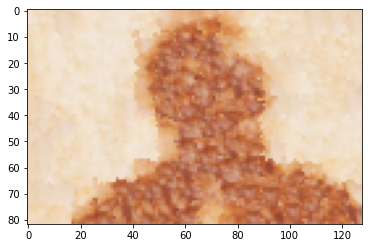

In [27]:
plt.imshow(avik_pasta[:-10, :-10, :])